# Beyond explicit matrix representations

# Overview

* Abstract linear operators in Python
* Some example with PyLops

# Abstract linear operators in Python

* So far, we have explicitly represented linear operators as a matrix
* For many algorithms we only need to be able to apply the operator and its adjoint to given input vectors

Convolution

$$f(x) = \int u(y) k(x - y) \mathrm{d}y.$$

can be efficiently implemented using FFT

In [1]:
#!pip install pylops

import matplotlib.pyplot as plt
import numpy as np
import pylops

s = .05
k = lambda x: np.exp(-0.5*((x-.5)/s)**2)/(n*s*np.sqrt(2*np.pi))

n = 1000
x = np.linspace(0,1,n)

K = pylops.signalprocessing.Convolve1D(n, h=k(x), offset=n//2)

u = np.heaviside(x-.3,0) - np.heaviside(x-.6,0)
f = K*u

Text(0.5, 0, '$x$')

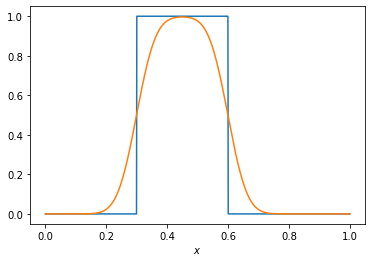

In [2]:
plt.plot(x,u,x,f)
plt.xlabel(r'$x$')

# An example with PyLops

## Image deblurring

Deconvolution by least-squares:

$$\min_u \|Ku - f\|_2^2.$$

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import lsqr
import pylops

sigma = 1e-16

s = .05
k = lambda x,y : np.exp(-0.5*((x-.5)**2+(y-.5)**2)/s**2)/(2*np.pi*(s*n)**2)

n = 32
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
xx, yy = np.meshgrid(x,y)

K = pylops.signalprocessing.Convolve2D(n*n, h=k(xx,yy), dims=(n,n),offset=(n // 2, n // 2))
u = ((np.heaviside(xx-.3,0) - np.heaviside(xx-.6,0))*(np.heaviside(yy-.3,0) - np.heaviside(yy-.6,0))).ravel()
f = K*u + sigma*np.random.randn(n**2)

uh = lsqr(K,f)[0]

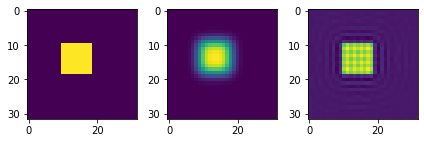

In [8]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(u.reshape((n,n)))
ax[1].imshow(f.reshape((n,n)))
ax[2].imshow(uh.reshape((n,n)))

plt.tight_layout()

## Tikhonov-regularised least-squares

$$\min_u \|Ku - f\|_2^2 + \alpha\|Lu\|_2^2,$$

can be re-written as

$$\min_u \left\|\left(\begin{matrix}K \\ \sqrt{\alpha} L\end{matrix}\right)u - \left(\begin{matrix}f\\0\end{matrix}\right)\right\|_2^2.$$


In [9]:
L = pylops.basicoperators.Laplacian((n,n))
A = lambda alpha : pylops.VStack((K,np.sqrt(alpha)*L))
b = np.concatenate((f,np.zeros(n**2)))

uh = lambda alpha : lsqr(A(alpha),b)[0]

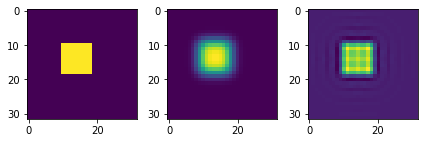

In [10]:
fig, ax = plt.subplots(1,3)

ax[0].imshow(u.reshape((n,n)))
ax[1].imshow(f.reshape((n,n)))
ax[2].imshow(uh(1e-6).reshape((n,n)))

plt.tight_layout()

## Sparse deconvolution

Look for a solution that is sparse in a wavelet basis

$$\min_{v} \|KWv - f\|_2^2 + \alpha \|v\|_1.$$

In [11]:
W = pylops.signalprocessing.DWT2D((n, n), wavelet="haar", level=5)

uh = lambda alpha :  W.H*pylops.optimization.sparsity.FISTA(K*W.H, f, 5000, alpha)[0]

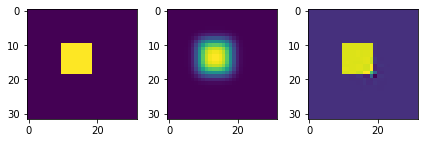

In [16]:
fig, ax = plt.subplots(1,3)

ax[0].imshow(u.reshape((n,n)))
ax[1].imshow(f.reshape((n,n)))
ax[2].imshow(uh(1e-6).reshape((n,n)))

plt.tight_layout()

# Exercise

* Install PyPlot on Google Colab using `!pip install pylops`
* Make a bias-variance plot for the deconvolution example
* Think how your own inverse problem could be cast in this framework